# **Simulation in closed-loop**

In [1]:
import os # For saving plots
import numpy as np
import matplotlib.pyplot as plt

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_LAB import LL_RT, PID_RT, IMCTuning
from package_DBR import SelectPath_RT, Delay_RT, FO_RT, myRound


## Dynamics and controller parameters

In [2]:
#DV 
Kp_ODV_SOPDT = 0.2951290424136788
T1_ODV_SOPDT = 182.2549613489765
T2_ODV_SOPDT = 13.184430234847984
theta_ODV_SOPDT = 28.999891911961512

#MV
Kp_OMV_SOPDT = 0.30788564834253684
T1_OMV_SOPDT = 183.81942938046797
T2_OMV_SOPDT = 3.2920224028341535e-12
theta_OMV_SOPDT = 20.015407110302775

#Operating points 
DV0 = 50 
MV0 = 50
PV0 = 49.3

# Set maximum and minimum MV values
MVmin = 0
MVmax = 100

# Coefficients
alpha = 1
gamma = 0.7

## Simulation parameters

In [3]:
TSim = 2000
Ts = 1
N = int(TSim/Ts) + 1 

## Scenarios

In [4]:
scenario = 1

# 1 : Response to setpoint change, with controller in auto mode, without FF, without perturbation
if scenario == 1:
    SPPath = {0: PV0 + 5, 1300: PV0 - 5}
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0+15, TSim: MV0+15}
    DVPath = {0: DV0}
    FF = False
    ManFF = True
# 2 : Response to perturbation, with controller in manual mode, without FF
elif scenario == 2:
    SPPath = {0: PV0}
    ManPath = {0: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    DVPath = {0: DV0, 1300: DV0 + 10}
    FF = False
    ManFF = True
# 3 : Response to perturbation, with controller in manual mode, with FF
elif scenario == 3:
    SPPath = {0: PV0}
    ManPath = {0: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    DVPath = {0: DV0, 1300: DV0 + 10}
    FF = True
    ManFF = True
# 4 : Response to perturbation, with controller in auto mode, without FF
elif scenario == 4:
    SPPath = {0: PV0}
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0}
    DVPath = {0: DV0, 1300: DV0 + 10}
    FF = False
    ManFF = False # Not needed
# 5 : Response to perturbation & setpoint change, with controller in auto mode, without FF
elif scenario == 5:
    SPPath = {0: PV0 + 5, 1000: PV0 - 5}
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0+15, TSim: MV0+15}
    DVPath = {0: DV0, 1600: DV0 + 10}
    FF = False
    ManFF = False # Not needed
# 6 : Response to perturbation, with controller in auto mode, with FF
elif scenario == 6:
    SPPath = {0: PV0}
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0}
    DVPath = {0: DV0, 1300: DV0 + 10}
    FF = True
    ManFF = False # Not needed
# 7 : Response to perturbation & setpoint change, with controller in auto mode, with FF
elif scenario == 7:
    SPPath = {0: PV0 + 5, 1000: PV0 - 5}
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0+15, TSim: MV0+15}
    DVPath = {0: DV0, 1600: DV0 + 10}
    FF = True
    ManFF = False # Not needed

## Simulation

In [5]:
# IMC tuning
Kc, Ti, Td = IMCTuning(Kp_OMV_SOPDT, T1_OMV_SOPDT, T2_OMV_SOPDT, theta_OMV_SOPDT, gamma, model="SOPDT")
print(f"Kc: {Kc}, Ti: {Ti}, Td: {Td}")

Kc: 4.015347211917375, Ti: 183.81942938047126, Td: 3.2920224028340946e-12


In [6]:
# Running simulation with chosen scenario

t = []

SP = []
PV = []
MAN = []
MV_MAN = []
DV = []
MVFF = []
MV = []
MVp = []
MVi = []
MVd = []
E = []
PV_p = []
PV_d = []

MVFF_Delay = []
MVFF_LL1 = []
MV_Delay_P = []
MV_FO_P = []
MV_Delay_D = []
MV_FO_D = []


for i in range(0, N):
    t.append(i * Ts)
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(ManPath, t, MAN)
    SelectPath_RT(MVManPath, t, MV_MAN)
    SelectPath_RT(DVPath, t, DV)
    
    # FeedForward
    Delay_RT(DV - DV0*np.ones_like(DV), max(theta_ODV_SOPDT-theta_OMV_SOPDT, 0), Ts, MVFF_Delay)
    LL_RT(MVFF_Delay, -Kp_ODV_SOPDT/Kp_OMV_SOPDT, T1_OMV_SOPDT, T1_ODV_SOPDT, Ts, MVFF_LL1)
    if FF == True:
        LL_RT(MVFF_LL1, 1, T2_OMV_SOPDT, T2_ODV_SOPDT, Ts, MVFF)
    else:
        LL_RT(MVFF_LL1, 0, T2_OMV_SOPDT, T2_ODV_SOPDT, Ts, MVFF) # Set MVFF to 0 if FF is disabled
    
    # PID
    PID_RT(SP, PV, MAN, MV_MAN, MVFF, Kc, Ti, Td, alpha, Ts, MVmin, MVmax, MV, MVp, MVi, MVd, E, ManFF, PV0)
    
    # Process
    Delay_RT(MV, theta_OMV_SOPDT, Ts, MV_Delay_P, MV0)
    FO_RT(MV_Delay_P, Kp_OMV_SOPDT, T1_OMV_SOPDT, Ts, MV_FO_P)
    FO_RT(MV_FO_P, 1, T2_OMV_SOPDT, Ts, PV_p)
    
    # Disturbance
    Delay_RT(DV - DV0*np.ones_like(DV), theta_ODV_SOPDT, Ts, MV_Delay_D)
    FO_RT(MV_Delay_D, Kp_ODV_SOPDT, T1_ODV_SOPDT, Ts, MV_FO_D)
    FO_RT(MV_FO_D, 1, T2_ODV_SOPDT, Ts, PV_d)
    
    PV.append(PV_p[-1] + PV_d[-1] + PV0 - Kp_OMV_SOPDT*MV0)

(45.0, 55.0)

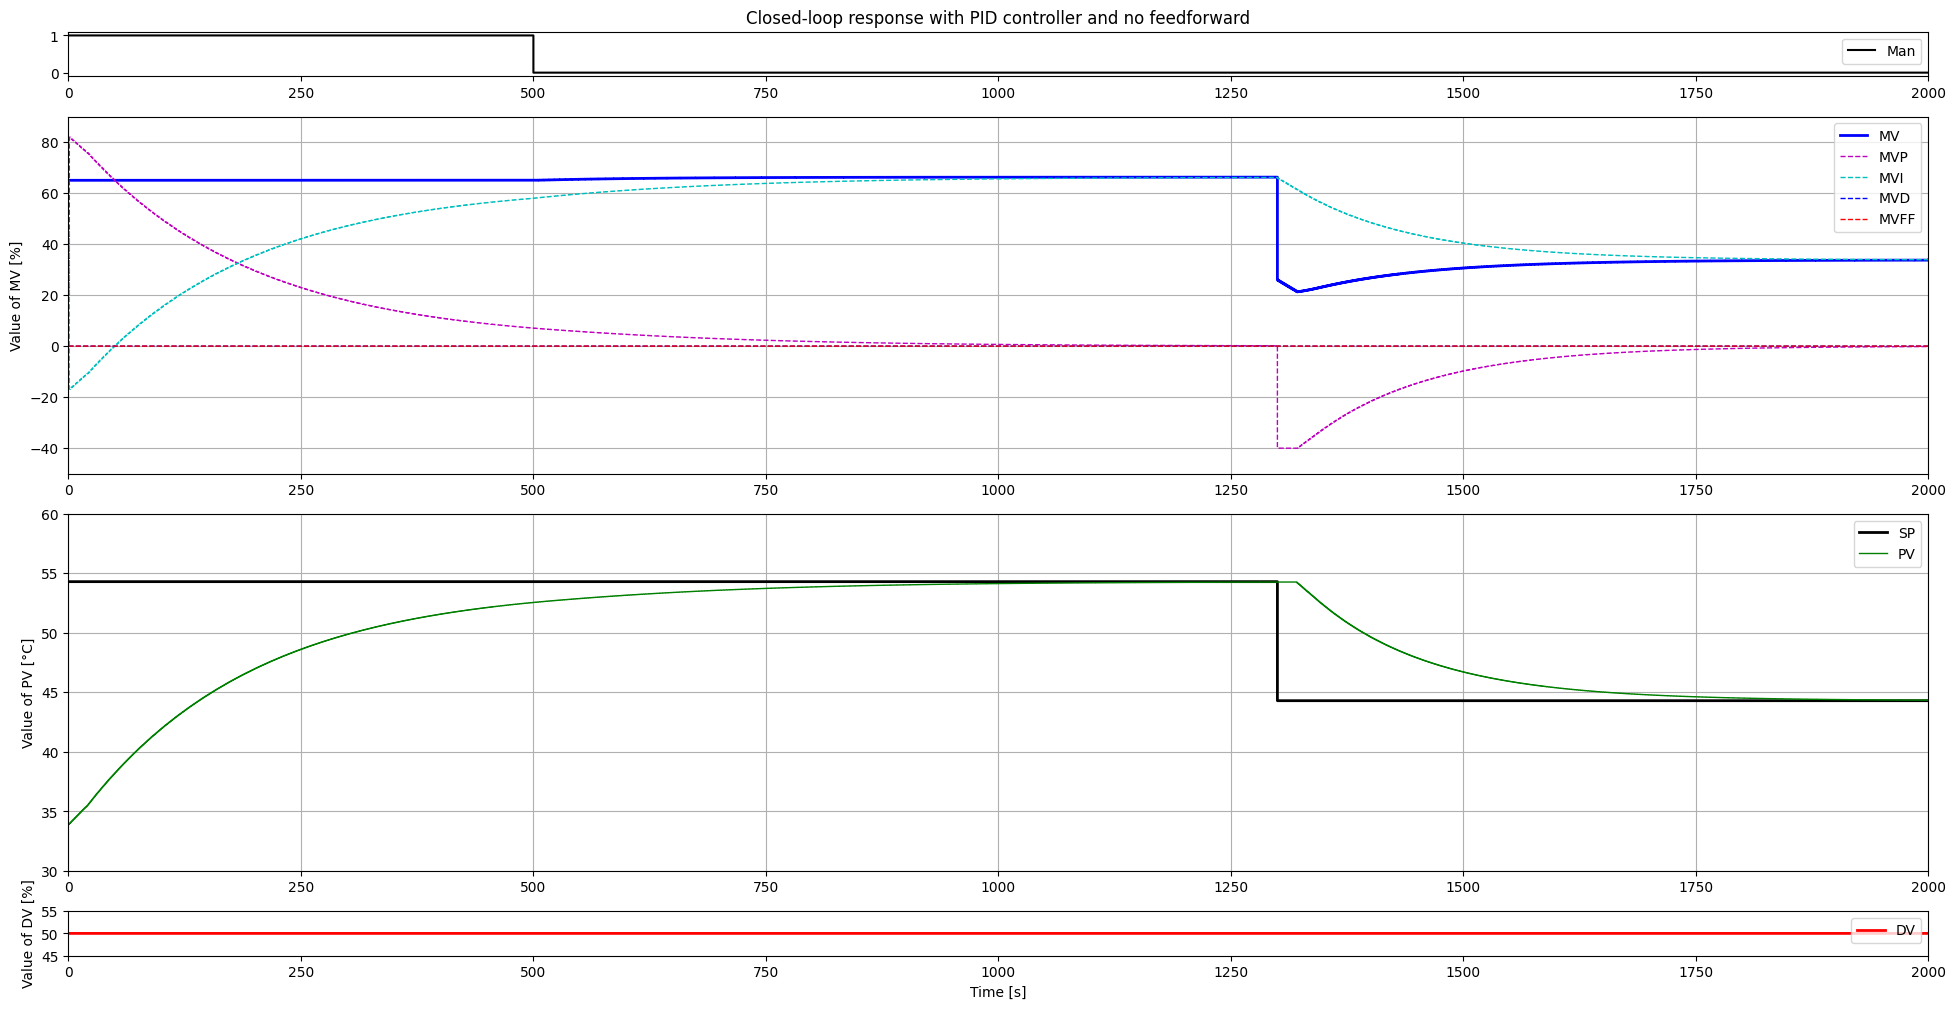

In [7]:
#Plot

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [1, 8, 8, 1]})
fig.set_figwidth(24)
fig.set_figheight(12)

l1, = ax1.step([0, TSim], [0, 1], 'k-', label="Man", where='post')
if scenario == 1 or scenario == 4 or scenario == 5:
    ax1.set_title('Closed-loop response with PID controller and no feedforward')
elif scenario == 2:
    ax1.set_title('Open-loop response with PID controller and no feedforward')
elif scenario == 3:
    ax1.set_title('Open-loop response with PID controller and feedforward')
elif scenario == 6 or scenario == 7:
    ax1.set_title('Closed-loop response with PID controller and feedforward')
ax1.legend(loc='best')

l2, = ax2.step([0,TSim],[0,100],'b-',linewidth=2,label="MV",where='post')
l3, = ax2.step([0,TSim],[0,100],'m--',linewidth=1,label="MVP",where='post')
l4, = ax2.step([0,TSim],[0,100],'c--',linewidth=1,label="MVI",where='post')
l5, = ax2.step([0,TSim],[0,100],'b--',linewidth=1,label="MVD",where='post')
l6, = ax2.step([0,TSim],[0,100],'r--',linewidth=1,label="MVFF",where='post')
ax2.set_ylabel("Value of MV [%]")
ax2.legend(loc='best')
ax2.grid()

l7, = ax3.step([0,TSim],[0,100],'k-',linewidth=2,label="SP",where='post')
l8, = ax3.step([0,TSim],[0,100],'g-',linewidth=1,label="PV",where='post')
ax3.set_ylabel("Value of PV [°C]")
ax3.legend(loc='best')
ax3.grid()

l9, = ax4.step([0,TSim],[0,100],'r-',linewidth=2,label="DV",where='post')
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Value of DV [%]")
ax4.legend(loc='best')

# Set Data
l1.set_data(t,MAN)
l2.set_data(t,MV)
l3.set_data(t,MVp)
l4.set_data(t,MVi)
l5.set_data(t,MVd)
l6.set_data(t,MVFF)
l7.set_data(t,SP)
l8.set_data(t,PV)
l9.set_data(t,DV)

ax1.set_xlim(0, t[-1])
ax2.set_xlim(0, t[-1])
ax3.set_xlim(0, t[-1])
ax4.set_xlim(0, t[-1])

MVMinLimit = myRound(np.min((np.min(MV),np.min(MVp),np.min(MVi),np.min(MVd),np.min(MVFF))),5)
MVMaxLimit = myRound(np.max((np.max(MV),np.max(MVp),np.max(MVi),np.max(MVd),np.max(MVFF))),5)

ax1.set_ylim(-0.1,1.1)
ax2.set_ylim(MVMinLimit-10, MVMaxLimit+10)
ax3.set_ylim(myRound(np.min((np.min(PV),np.min(SP))),5)-5, myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)

# Save plot
# if not os.path.exists('Plots'):
#     os.makedirs('Plots')

# plt.savefig(f'Plots/Simulation_scenario_{scenario}.png',transparent=True)
# plt.savefig(f'Plots/Simulation_scenario_{scenario}.pdf',transparent=True)

# Save data
# t = np.array(t)
# MAN = np.array(MAN)
# MV = np.array(MV)
# MVp = np.array(MVp)
# MVi = np.array(MVi)
# MVd = np.array(MVd)
# MVFF = np.array(MVFF)
# SP = np.array(SP)
# PV = np.array(PV)
# DV = np.array(DV)

# data = np.vstack((t.T, MAN.T, MV.T, MVp.T, MVi.T, MVd.T, MVFF.T, SP.T, PV.T, DV.T))
# data = data.T
# if not os.path.exists('Data'):
#     os.makedirs('Data')
# nameFile = f'Data/Experiment_scenario_{scenario}.txt'
# np.savetxt(nameFile,data,delimiter=',',header='t,MAN,MV,MVp,MVi,MVd,MVFF,SP,PV,DV',comments='')